In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\shudd\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\shudd\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\shudd\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\shudd\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\shudd\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\shudd\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

In [ ]:
class PINN(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh()
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.k = nn.Parameter(torch.tensor(0.5))
    def forward(self, t):
        # exponential ensures positivity
        return torch.exp(self.net(t))


In [ ]:
# time domain
T_final = 5.0
N_collocation = 200


In [29]:
def sample_collocation_points():
    t = torch.rand(N_collocation, 1) * T_final
    t.requires_grad_(True)
    return t

In [25]:
def physics_residual(model, t):
    N_hat=model(t)
    k = torch.exp(model.k)
    dN_dt = autograd.grad(N_hat, t, grad_outputs=torch.ones_like(N_hat), create_graph=True)[0]
    residual= dN_dt + k * N_hat
    return residual

In [30]:

def loss_function(model):
    # physics loss
    t_col = sample_collocation_points()
    res = physics_residual(model, t_col)
    physics_loss = torch.mean(res**2)
    # weak initial condition
    t0 = torch.zeros(1, 1, requires_grad=True)
    N0_pred = model(t0)
    N0_true = torch.tensor([[1.0]])  # arbitrary scale
    ic_loss = (N0_pred - N0_true)**2
    
    return physics_loss + ic_loss

In [27]:
model=PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 3.144197463989258
Epoch 100, Loss: 0.026291832327842712
Epoch 200, Loss: 0.008378236554563046
Epoch 300, Loss: 0.006195877678692341
Epoch 400, Loss: 0.004713721573352814
Epoch 500, Loss: 0.0035312953405082226
Epoch 600, Loss: 0.002840752014890313
Epoch 700, Loss: 0.0021775595378130674
Epoch 800, Loss: 0.001852481858804822
Epoch 900, Loss: 0.001588351558893919
Epoch 1000, Loss: 0.0013226823648437858
Epoch 1100, Loss: 0.0011056490475311875
Epoch 1200, Loss: 0.0009721491951495409
Epoch 1300, Loss: 0.0008693963172845542
Epoch 1400, Loss: 0.0007563333492726088
Epoch 1500, Loss: 0.0006120072212070227
Epoch 1600, Loss: 0.0006027686758898199
Epoch 1700, Loss: 0.0005071025225333869
Epoch 1800, Loss: 0.00046406546607613564
Epoch 1900, Loss: 0.0004129830049350858
Epoch 2000, Loss: 0.0003676998021546751
Epoch 2100, Loss: 0.00032596924575045705
Epoch 2200, Loss: 0.00031963398214429617
Epoch 2300, Loss: 0.0002744254597928375
Epoch 2400, Loss: 0.00024403180577792227
Epoch 2500, Loss: 0

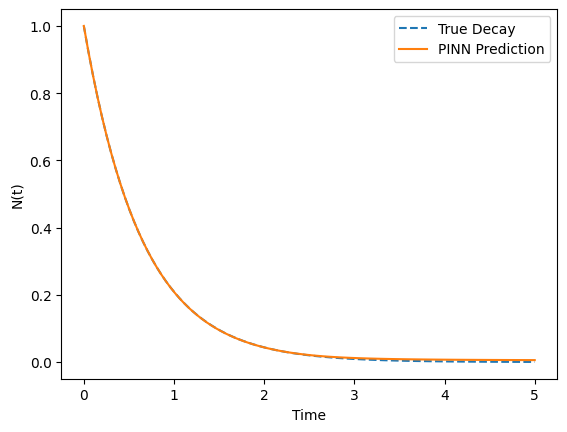

In [28]:
#plot actual vs predicted
t_test = torch.linspace(0, T_final, 100).unsqueeze(1)
N_pred = model(t_test).detach().numpy()
k_learned = torch.exp(model.k).item()
N_true = np.exp(-k_learned * t_test.numpy())
plt.plot(t_test.numpy(), N_true, label='True Decay', linestyle='--')
plt.plot(t_test.numpy(), N_pred, label='PINN Prediction')
plt.xlabel('Time')
plt.ylabel('N(t)')
plt.legend()
plt.show()
